In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.cluster import KMeans
import optuna
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from kneed import KneeLocator

In [2]:
def load_data():
    df = pd.read_csv("diabetes.csv")
    copy_df = df.copy()
    
    clean(copy_df)
    
    return copy_df

In [3]:
def clean(df):
    for col in df:
        df[col].fillna(df[col].mean(), inplace = True)
    return df

In [4]:
copy_df = load_data()

In [5]:
copy_df.shape

(768, 9)

In [6]:
def score(X, y, model):
    k_fold = KFold(n_splits = 5, shuffle=True, random_state = 42)
    score = cross_val_score(model, X, y, cv= k_fold, scoring = 'accuracy')
    score = score.mean()
    return score

In [7]:
model = XGBClassifier()

In [8]:
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']
X = copy_df[features]
y = copy_df['Outcome']
train_x, test_x, train_y, test_y = train_test_split(X, y)

In [9]:
baseline_score = score(train_x, train_y, model)

In [10]:
print(f"Baseline score is {baseline_score}")

Baseline score is 0.7447376311844078


In [11]:
model.fit(train_x, train_y)
prediction = model.predict(test_x)

In [12]:
prediction

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0])

In [13]:
confusion_matrix = metrics.confusion_matrix(test_y, prediction)

In [14]:
confusion_matrix

array([[102,  18],
       [ 35,  37]])

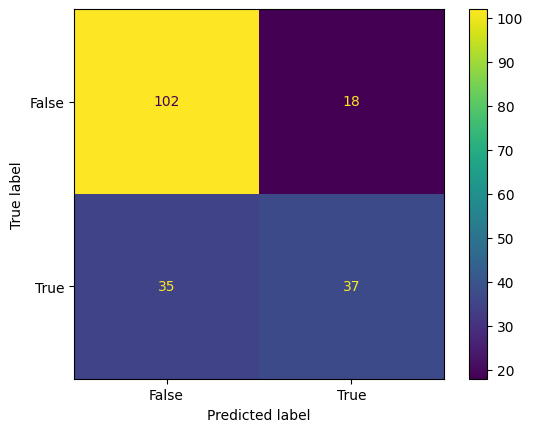

In [15]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=[False, True])
cm_display.plot()
plt.show()

In [16]:
model_1 = RandomForestClassifier()
score = score(train_x, train_y, model)
print(f"Random forest score {score}")

Random forest score 0.7447376311844078


In [17]:
model_1.fit(train_x, train_y)
prediction_1 = model_1.predict(test_x)

In [18]:
confusion_matrix = metrics.confusion_matrix(test_y, prediction_1)
confusion_matrix

array([[110,  10],
       [ 36,  36]])

In [19]:
def make_mi_score(X, y):
    mi_score = mutual_info_regression(X, y, random_state= 0)
    mi_score = pd.Series(mi_score, name = "MI Scores", index = X.columns)
    mi_score = mi_score.sort_values(ascending = False)
    
    return mi_score

In [20]:
mi_result = make_mi_score(train_x, train_y)
mi_result

Glucose                     0.117058
BMI                         0.094686
Pregnancies                 0.059932
SkinThickness               0.045706
Age                         0.040773
BloodPressure               0.024051
Insulin                     0.023978
DiabetesPedigreeFunction    0.005720
Name: MI Scores, dtype: float64

In [21]:
cluster_df = copy_df.copy()
km = KMeans()
km.fit(cluster_df[['Glucose', 'Insulin',
       'BMI', 'Age']])

/home/tawhid885/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans()

In [22]:
cluster_predict = km.predict(cluster_df[['Glucose', 'Insulin',
       'BMI', 'Age']])

In [23]:
cluster_predict.shape

(768,)

In [24]:
cluster_df['cluster'] = cluster_predict

In [25]:
cluster_df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'cluster'],
      dtype='object')

In [26]:
cluster_df['cluster'].unique()

array([6, 1, 3, 4, 2, 5, 0, 7], dtype=int32)

In [27]:
wcss = []
cluster_range= (range(1,15))
for k in cluster_range:
    km2 = KMeans(n_clusters = k)
    km2.fit(cluster_df[['Glucose', 'Insulin',
       'BMI', 'Age']])
    wcss.append(km2.inertia_)

wcss

/home/tawhid885/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/tawhid885/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/tawhid885/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/tawhid885/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

[11124484.72071614,
 4677406.028924948,
 2467358.652936996,
 1716734.0965839815,
 1308327.396698884,
 1044506.4074491566,
 878793.5495888223,
 743968.3204474181,
 670038.9300949039,
 607003.1145746903,
 552330.5420060584,
 515978.5709276804,
 481636.3989320992,
 451543.82786310225]

Text(0, 0.5, 'wcss')

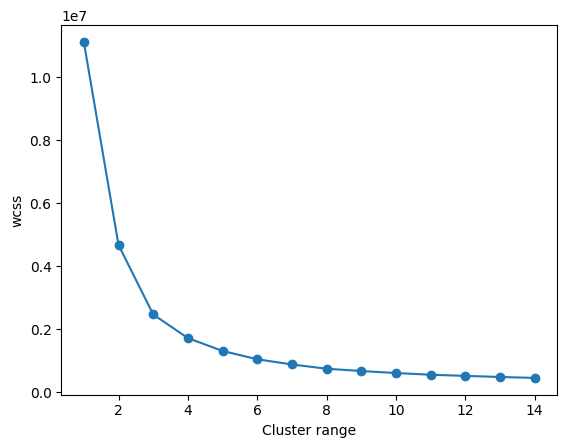

In [28]:
plt.plot(cluster_range, wcss, marker="o")
plt.xlabel("Cluster range")
plt.ylabel("wcss")

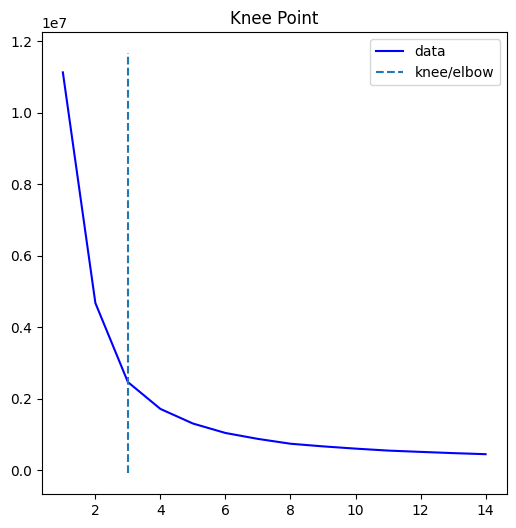

In [29]:
kn = KneeLocator(cluster_range, wcss, curve = "convex", direction= "decreasing")
kn.plot_knee()

In [30]:
optimize_km = KMeans(n_clusters = 3)
optimize_km.fit(cluster_df[['Glucose', 'Insulin',
       'BMI', 'Age']])
cluster_df['optimize_cluster'] = optimize_km.predict(cluster_df[['Glucose', 'Insulin',
       'BMI', 'Age']])
cluster_df.drop("cluster", axis =1, inplace = True)

/home/tawhid885/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [31]:
cluster_df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome',
       'optimize_cluster'],
      dtype='object')

In [32]:
cluster_df['optimize_cluster'].unique()

array([1, 0, 2], dtype=int32)

In [33]:
cluster_df.shape

(768, 10)

In [34]:
cluster_df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome',
       'optimize_cluster'],
      dtype='object')

In [35]:
X = cluster_df.copy()
y = X.pop('Outcome')

In [36]:
train_x, test_x, train_y, test_y = train_test_split(X, y)

In [37]:
score = score(train_x, train_y, model)

TypeError: 'numpy.float64' object is not callable

In [ ]:
print(f"Score after clustering is {score}")

In [ ]:
model.fit(train_x, train_y)

In [38]:
model_1.fit(train_x, train_y)

RandomForestClassifier()

In [39]:
prediction = model.predict(test_x)

ValueError: feature_names mismatch: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'] ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'optimize_cluster']
training data did not have the following fields: optimize_cluster

In [40]:
prediction_1 = model_1.predict(test_x)

In [41]:
confusion_matrix = metrics.confusion_matrix(test_y, prediction)
confusion_matrix_1 = metrics.confusion_matrix(test_y, prediction_1)

In [42]:
confusion_matrix

array([[95, 35],
       [42, 20]])

In [43]:
confusion_matrix_1

array([[110,  20],
       [ 24,  38]])

In [44]:
score_1 = score(train_x, train_y, model_1)

TypeError: 'numpy.float64' object is not callable

In [45]:
score_1

NameError: name 'score_1' is not defined

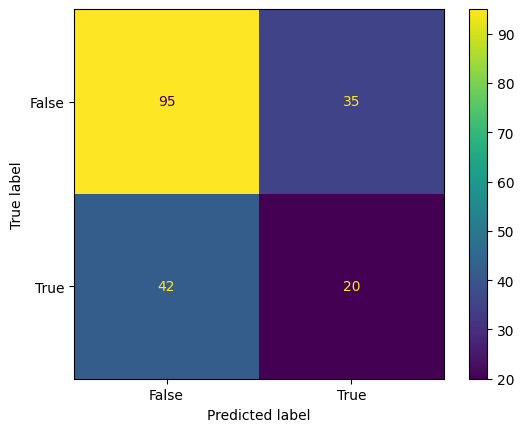

In [46]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=[False, True])
cm_display.plot()
plt.show()

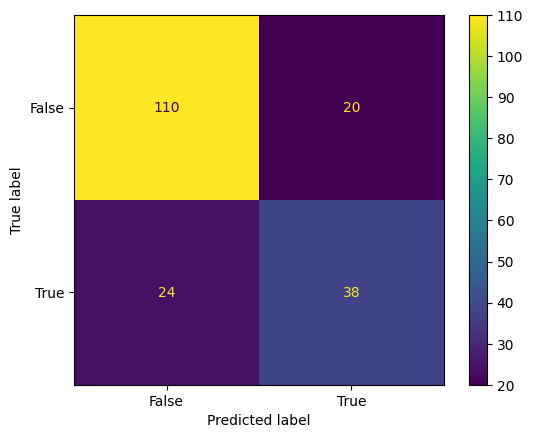

In [47]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_1, display_labels=[False, True])
cm_display.plot()
plt.show()

In [48]:
def objective(trial):
    params = {
        'objective': 'multi:softmax',
        'num_class': 3,
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
    }

    model = XGBClassifier(**params)
    
    kFold = KFold(n_splits = 5, shuffle = True, random_state = 42)
    score = cross_val_score(model, X, y, cv = kFold, scoring = "accuracy")
    score = score.mean()
    return score
# RandomForestClassifier()

In [49]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials= 100)

best_params = study.best_params
print(f"Best hyperparameters for model {best_params}")

[I 2024-07-25 00:46:13,535] A new study created in memory with name: no-name-5cde8eb7-9cb7-4ced-9aec-55852802756c
/tmp/ipykernel_9081/713915592.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
[I 2024-07-25 00:46:21,029] Trial 0 finished with value: 0.7656480774127832 and parameters: {'booster': 'dart', 'max_depth': 8, 'learning_rate': 0.09090656001836138, 'subsample': 0.639669639759512, 'colsample_bytree': 0.6347826743385938}. Best is trial 0 with value: 0.7656480774127832.
/tmp/ipykernel_9081/713915592.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform(

/tmp/ipykernel_9081/713915592.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
/home/tawhid885/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:46:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/tawhid885/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:46:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/tawhid885/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:46:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "max_depth", "su

[I 2024-07-25 00:47:36,758] Trial 19 finished with value: 0.769493251846193 and parameters: {'booster': 'dart', 'max_depth': 4, 'learning_rate': 0.022637387176570593, 'subsample': 0.6934707392675898, 'colsample_bytree': 0.7492836844352084}. Best is trial 16 with value: 0.7733978439860792.
/tmp/ipykernel_9081/713915592.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
[I 2024-07-25 00:47:43,340] Trial 20 finished with value: 0.7668958492487905 and parameters: {'booster': 'dart', 'max_depth': 6, 'learning_rate': 0.015598977525902091, 'subsample': 0.559476455435823, 'colsample_bytree': 0.9197699688433241}. Best is trial 16 with value: 0.7733978439860792.
/tmp/ipykernel_9081/713915592.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This 

[I 2024-07-25 00:49:08,241] Trial 33 finished with value: 0.7708004413886768 and parameters: {'booster': 'dart', 'max_depth': 3, 'learning_rate': 0.025447839431015237, 'subsample': 0.5673130055582063, 'colsample_bytree': 0.8248129203232708}. Best is trial 26 with value: 0.7773194126135302.
/tmp/ipykernel_9081/713915592.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
[I 2024-07-25 00:49:14,862] Trial 34 finished with value: 0.7721246074187251 and parameters: {'booster': 'dart', 'max_depth': 3, 'learning_rate': 0.014574192871512893, 'subsample': 0.6197682352322952, 'colsample_bytree': 0.7760441333424679}. Best is trial 26 with value: 0.7773194126135302.
/tmp/ipykernel_9081/713915592.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

/tmp/ipykernel_9081/713915592.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
[I 2024-07-25 00:49:36,603] Trial 41 finished with value: 0.7760122230710467 and parameters: {'booster': 'dart', 'max_depth': 3, 'learning_rate': 0.02319305461101523, 'subsample': 0.6756356431783086, 'colsample_bytree': 0.7516410581754812}. Best is trial 26 with value: 0.7773194126135302.
/tmp/ipykernel_9081/713915592.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
[I 2024-07-25 00:49:42,505] Trial 42 finished with value: 0.7681945505474916 and p

[I 2024-07-25 00:50:44,195] Trial 52 finished with value: 0.7825227060521178 and parameters: {'booster': 'dart', 'max_depth': 4, 'learning_rate': 0.04061867273217935, 'subsample': 0.5363024811125284, 'colsample_bytree': 0.7161344232467516}. Best is trial 52 with value: 0.7825227060521178.
/tmp/ipykernel_9081/713915592.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
[I 2024-07-25 00:50:49,902] Trial 53 finished with value: 0.7681860623037093 and parameters: {'booster': 'dart', 'max_depth': 4, 'learning_rate': 0.041000721202845355, 'subsample': 0.5005750977980253, 'colsample_bytree': 0.70829196569045}. Best is trial 52 with value: 0.7825227060521178.
/tmp/ipykernel_9081/713915592.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This f

[I 2024-07-25 00:51:21,190] Trial 66 finished with value: 0.7656056361938715 and parameters: {'booster': 'gbtree', 'max_depth': 4, 'learning_rate': 0.04456764604418109, 'subsample': 0.9974296809882542, 'colsample_bytree': 0.5246843094974536}. Best is trial 52 with value: 0.7825227060521178.
/tmp/ipykernel_9081/713915592.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
[I 2024-07-25 00:51:22,001] Trial 67 finished with value: 0.7682285035226212 and parameters: {'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.053114969179896575, 'subsample': 0.8682836610896327, 'colsample_bytree': 0.8643943938966356}. Best is trial 52 with value: 0.7825227060521178.
/tmp/ipykernel_9081/713915592.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. 

[I 2024-07-25 00:52:26,974] Trial 78 finished with value: 0.7786181139122316 and parameters: {'booster': 'dart', 'max_depth': 3, 'learning_rate': 0.038289916037240364, 'subsample': 0.9733565948896906, 'colsample_bytree': 0.7533211435537842}. Best is trial 52 with value: 0.7825227060521178.
/tmp/ipykernel_9081/713915592.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
[I 2024-07-25 00:52:32,430] Trial 79 finished with value: 0.7773194126135303 and parameters: {'booster': 'dart', 'max_depth': 3, 'learning_rate': 0.035673413727511434, 'subsample': 0.9780506687837102, 'colsample_bytree': 0.7595579305254834}. Best is trial 52 with value: 0.7825227060521178.
/tmp/ipykernel_9081/713915592.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

[I 2024-07-25 00:54:18,507] Trial 92 finished with value: 0.7798998387233681 and parameters: {'booster': 'dart', 'max_depth': 3, 'learning_rate': 0.03098244825838857, 'subsample': 0.9885166099406713, 'colsample_bytree': 0.7675878207738134}. Best is trial 52 with value: 0.7825227060521178.
/tmp/ipykernel_9081/713915592.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
[I 2024-07-25 00:54:26,255] Trial 93 finished with value: 0.7799168152109329 and parameters: {'booster': 'dart', 'max_depth': 3, 'learning_rate': 0.030757158396137046, 'subsample': 0.9878691018565925, 'colsample_bytree': 0.7659366159401436}. Best is trial 52 with value: 0.7825227060521178.
/tmp/ipykernel_9081/713915592.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This

Best hyperparameters for model {'booster': 'dart', 'max_depth': 4, 'learning_rate': 0.04061867273217935, 'subsample': 0.5363024811125284, 'colsample_bytree': 0.7161344232467516}


In [52]:
# optimized_score = score(train_x, train_y, XGBClassifier(**best_params))

In [53]:
# optimized_score

In [ ]:
def objective(trial):
    params = {
        'objective': 'multi:softmax',
        'num_class': 3,
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
    }

    model = RandomForestClassifier(**params)
    
    kFold = KFold(n_splits = 5, shuffle = True, random_state = 42)
    score = cross_val_score(model, X, y, cv = kFold, scoring = "accuracy")
    score = score.mean()
    return score

In [ ]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# best_params = study.best_params
# print(f"Best hyperparameters for model_1 {best_params}")

In [66]:
accuracy_score(test_y, prediction)

0.5989583333333334

In [67]:
fpr, tpr, thresholds= roc_curve(test_y, prediction)

In [68]:
roc_auc_score(test_y, prediction)

0.5266749379652605

Text(0, 0.5, 'True Positive Rate')

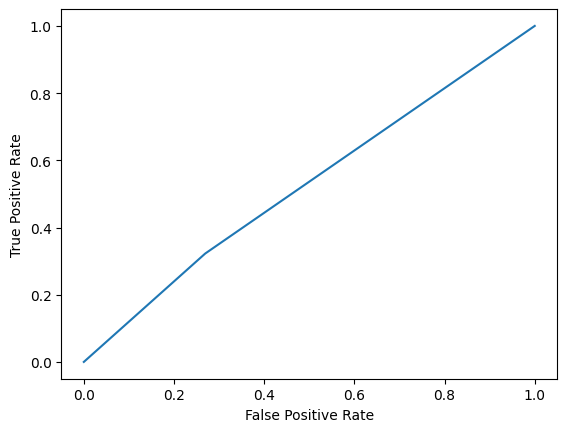

In [69]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [70]:
accuracy_score(test_y, prediction_1)

0.7708333333333334

In [71]:
fpr, tpr, thresholds= roc_curve(test_y, prediction_1)

In [72]:
roc_auc_score(test_y, prediction_1)

0.7295285359801489

Text(0, 0.5, 'True Positive Rate')

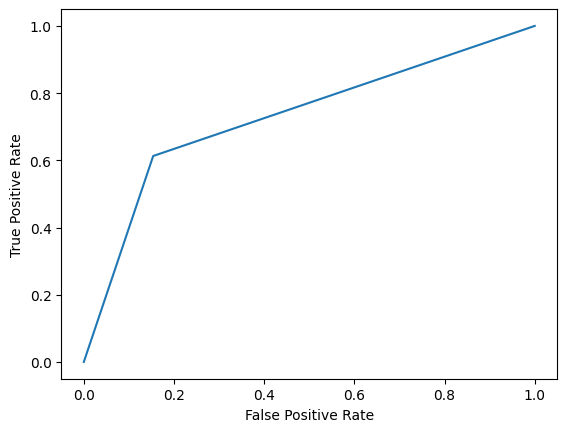

In [73]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')